In [ ]:
!pip install pandas==1.0.3 regex matplotlib==3.2.1 cython grpcio-tools scikit-learn pyarrow fastparquet plotly memoized-property opt-einsum==2.3.2 > /dev/null 2>&1

In [ ]:
!pip install --upgrade git+https://github.com/frreiss/text-extensions-for-pandas > /dev/null 2>&1

In [ ]:
%load util.py

# demographics_us_data.ipynb

Draw charts of aggregated COVID-19 statistics over time for the United States, broken down according to various demographic metrics.

Inputs:
* `data/us_counties_clean.csv`: The contents of `data/us_counties.csv` after data cleaning by `clean.ipynb`
* `data/us_counties_clean_meta.json`: Column type metadata for reading `data/us_counties_clean.csv` with `pd.read_csv()`
* `data/us_counties_income.csv`: Income statistics by county for the united states, produced from U.S. Census Bureau raw data by `etl_us_census.ipynb`



In [1]:
# Initialization boilerplate

# Ensure a consistent Python environment.
#import sys
#sys.path.append("..")  # Local libraries are in the directory above "notebooks"
#import env
#env.maybe_install_libs()
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

_DATA_DIR = os.getenv('COVID_DATA_DIR', '../data')

In [2]:
# Size of the line charts in this notebook, in inches
FIGSIZE = (13, 8)

# Read in the CSV file and apply the saved type information
csv_file = os.path.join(_DATA_DIR, "us_counties_clean.csv")
meta_file = os.path.join(_DATA_DIR, "us_counties_clean_meta.json")

# Read column type metadata
with open(meta_file) as f:
    cases_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
cases_meta["Date"] = "object"

cases_vertical = (
    pd
    .read_csv(csv_file, dtype=cases_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-04-23  Wyoming   Weston        6927          0       0          0   
      2020-04-24  Wyoming   Weston        6927          0       0          0   
      2020-04-25  Wyoming   Weston        6927          0       0          0   
      2020-04-26  Wyoming   Weston        6927          0       0          0   
      2020-04-27  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22              False           False              False  
      2020-01-23              False           False              False  
      2020-01-24              False           False              False  
      2020-01-25              False           False              False  
      2020-01-26              False           False              False  
...                             ...             ...                ...  
56045 2020-04-23              False           False              False  
      2020-04-24              False           False              False  
      2020-04-25              False           False              False  
      2020-04-26              False           False              False  
      2020-04-27              False           False              False  

[304774 rows x 9 columns]

In [3]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
for col in ["Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"]:
    cases_vertical[col] = cases_vertical[col].astype(np.int8)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-04-23  Wyoming   Weston        6927          0       0          0   
      2020-04-24  Wyoming   Weston        6927          0       0          0   
      2020-04-25  Wyoming   Weston        6927          0       0          0   
      2020-04-26  Wyoming   Weston        6927          0       0          0   
      2020-04-27  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22                  0               0                  0  
      2020-01-23                  0               0                  0  
      2020-01-24                  0               0                  0  
      2020-01-25                  0               0                  0  
      2020-01-26                  0               0                  0  
...                             ...             ...                ...  
56045 2020-04-23                  0               0                  0  
      2020-04-24                  0               0                  0  
      2020-04-25                  0               0                  0  
      2020-04-26                  0               0                  0  
      2020-04-27                  0               0                  0  

[304774 rows x 9 columns]

In [4]:
# Use Text Extensions for Pandas to collapse each time series or mask down to a single cell
ALL_TS_COLS = [
    "Confirmed", "Deaths", "Recovered", 
    "Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"]
cases, dates = util.collapse_time_series(cases_vertical, ALL_TS_COLS)
cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
# Cut off the "almost all zeros" sections at the beginning of each time series
min_confirmed = 100
first_time_above_min = np.argmax(np.max(cases["Confirmed"].values, axis=0) >= min_confirmed)

print(f"Dropping the first {first_time_above_min} elements of each time series.")

for ts_col_name in ALL_TS_COLS:
    cases[ts_col_name] = cases[ts_col_name].values[:,first_time_above_min:]

# Update our dates list too.
dates = dates[first_time_above_min:]

cases

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


# Part 1: Population

In [6]:
# Label counties by decile of population. 
# Break out demographic information into a third dataframe, again on
# the same index as the `cases` dataframe.
population_quantiles = cases["Population"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
population = cases[["State", "County", "Population"]].copy()
population["Population_Bin"] = pd.cut(population["Population"], 
                                        bins=([0.0] + population_quantiles.to_list()))
population

,State,County,Population,Population_Bin
FIPS,,,,
1001,Alabama,Autauga,55869,"(54018.7, 94275.6]"
1003,Alabama,Baldwin,223234,"(213707.3, 10039107.0]"
1005,Alabama,Barbour,24686,"(18693.0, 25726.0]"
1007,Alabama,Bibb,22394,"(18693.0, 25726.0]"
1009,Alabama,Blount,57826,"(54018.7, 94275.6]"
...,...,...,...,...
56037,Wyoming,Sweetwater,42343,"(36743.0, 54018.7]"
56039,Wyoming,Teton,23464,"(18693.0, 25726.0]"
56041,Wyoming,Uinta,20226,"(18693.0, 25726.0]"


In [7]:
# Group all the time series by decile of population

cases_with_bin = cases.copy()
cases_with_bin["Population_Bin"] = population["Population_Bin"]

# TODO: Replace outliers with interpolated values before aggregating.

series_by_pop = cases_with_bin.groupby("Population_Bin").aggregate({
    "Population": "sum",
    "Confirmed": "sum",
    "Deaths" : "sum",
    "Recovered" : "sum"
})

# Use the total populations to compute aggregated normalized time series
series_by_pop["Confirmed_per_100"] = 100.0 * series_by_pop["Confirmed"] / series_by_pop["Population"]
series_by_pop["Deaths_per_100"] = 100.0 * series_by_pop["Deaths"] / series_by_pop["Population"]
series_by_pop["Recovered_per_100"] = 100.0 * series_by_pop["Recovered"] / series_by_pop["Population"]

series_by_pop

,Population,Confirmed,Deaths,Recovered,Confirmed_per_100,Deaths_per_100,Recovered_per_100
Population_Bin,,,,,,,
"(0.0, 4992.2]",872420,"[0, 0, 0, 1, 1, 1, 1, 1, 2, 3, 5, 8, 9, 11, 15...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0001146236904243369, 0.00011...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(4992.2, 8808.4]",2184561,"[0, 2, 2, 3, 3, 3, 3, 6, 8, 12, 25, 29, 39, 47...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 9.15515748930792e-05, 9.15515748930792e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(8808.4, 13335.6]",3456224,"[0, 1, 1, 1, 2, 3, 5, 5, 7, 11, 19, 22, 35, 43...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 2.8933309878063458e-05, 2.89333098780634...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(13335.6, 18693.0]",5000037,"[1, 12, 18, 19, 23, 23, 28, 31, 36, 47, 64, 78...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.9999852001095193e-05, 0.0002399982240131423...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(18693.0, 25726.0]",6934301,"[2, 6, 6, 9, 14, 14, 16, 25, 35, 56, 77, 106, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.884212842794104e-05, 8.652638528382313e-05,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4421064213970...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(25726.0, 36743.0]",9707534,"[4, 4, 6, 11, 15, 16, 26, 41, 56, 69, 119, 161...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4.120510935114933e-05, 4.120510935114933e-05,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.03012773...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(36743.0, 54018.7]",13857842,"[5, 9, 10, 15, 26, 23, 38, 58, 76, 103, 153, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.6080653827630593e-05, 6.494517688973507e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(54018.7, 94275.6]",22136348,"[17, 26, 32, 58, 93, 95, 122, 170, 209, 273, 4...","[0, 0, 0, 0, 1, 1, 2, 2, 4, 8, 11, 14, 15, 16,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7.67967688256437e-05, 0.0001174538817333374, ...","[0.0, 0.0, 0.0, 0.0, 4.517456989743747e-06, 4....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(94275.6, 213707.3]",44626025,"[31, 53, 74, 113, 152, 168, 232, 307, 431, 596...","[2, 3, 3, 4, 4, 4, 4, 5, 6, 9, 14, 16, 21, 27,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6.946619153285555e-05, 0.00011876477907230143...","[4.4816897763132616e-06, 6.7225346644698915e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
# Define a function to plot one time series from the `series_by_pop` 
# dataframe or anything similar

# Globally adjust the font size for matplotlib.
plt.rcParams.update({'font.size': 14})

_MATPLOTLIB_FIGSIZE=(14, 7)

def draw_plot_matplotlib(summary_df: pd.DataFrame, summary_descr: str,
              col_name: str, col_descr: str):
    plt.figure(figsize=_MATPLOTLIB_FIGSIZE)
    for i in range(len(summary_df.index)):
        bin_interval = summary_df.index[i]
        bin_name = f"{int(bin_interval.left)}-{int(bin_interval.right)}"
        color_interval = 1.0 / len(summary_df.index)
    
        color = (i * color_interval, 0, (len(summary_df.index) - i) * color_interval)

        x_values = [pd.Timestamp(d) for d in dates]
        y_values = summary_df.iloc[i][col_name]._tensor
        
        plt.plot(x_values, y_values, c=color, label=bin_name, 
                 alpha=0.7, linewidth=4.0)
    plt.title(f"{col_descr} by {summary_descr}")
    plt.legend()
    plt.show()

# Plotly version, currently not used because it requires a JupyterLab
# extension to run.
def draw_plot_plotly(summary_df: pd.DataFrame, summary_descr: str,
              col_name: str, col_descr: str):
    import plotly.graph_objects as go
    fig = go.Figure()
    
    for i in range(len(summary_df.index)):
        bin_interval = summary_df.index[i]
        bin_name = f"{int(bin_interval.left)}-{int(bin_interval.right)}"
        color_interval = 255 / len(summary_df.index)
    
        color = f"rgb({i * color_interval}, 0, {(len(summary_df.index) - i) * color_interval})"

        x_values = [pd.Timestamp(d) for d in dates]
        y_values = summary_df.iloc[i][col_name]._tensor
        
        fig.add_trace(go.Scatter(x=x_values, y=y_values,
                                 mode="lines+markers",
                                 name=bin_name,
                                 marker_color=color,
                                 line_color=color))
    fig.update_layout(
        title=f"{col_descr} by {summary_descr}",
        xaxis_title="Date",
        yaxis_title=f"{col_descr} (log scale)",
        #yaxis_type="log",
        legend_title=summary_descr)
    fig.show()

    
draw_plot = draw_plot_matplotlib

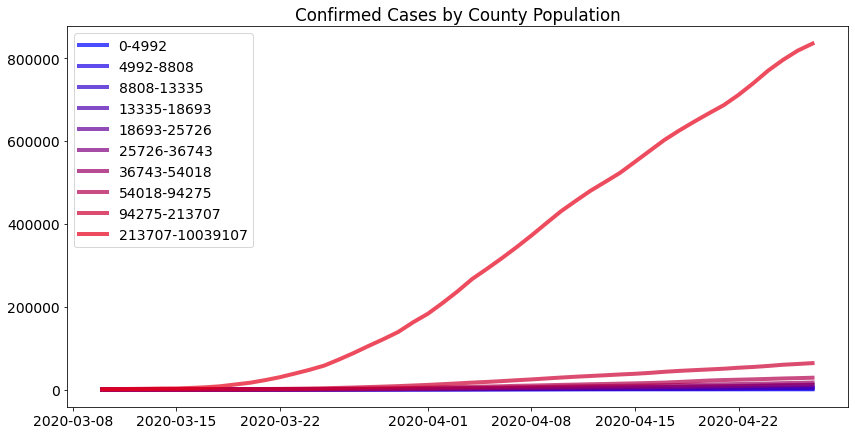

In [9]:
draw_plot(series_by_pop, "County Population", "Confirmed", "Confirmed Cases")

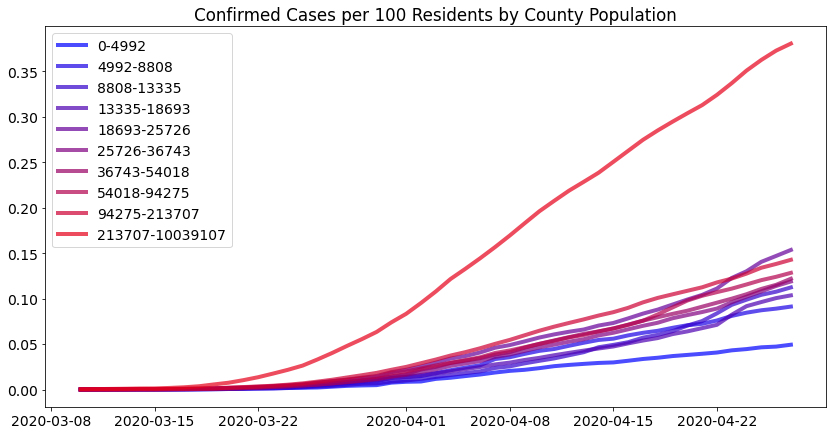

In [10]:
draw_plot(series_by_pop, "County Population", "Confirmed_per_100", "Confirmed Cases per 100 Residents")

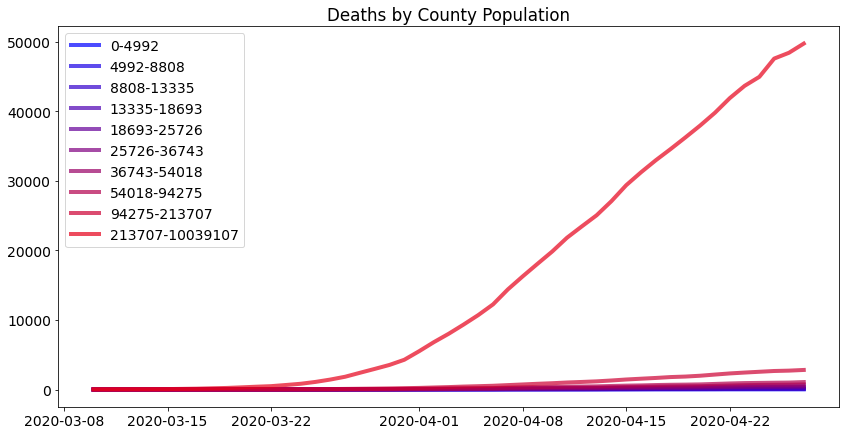

In [11]:
draw_plot(series_by_pop, "County Population", "Deaths", "Deaths")

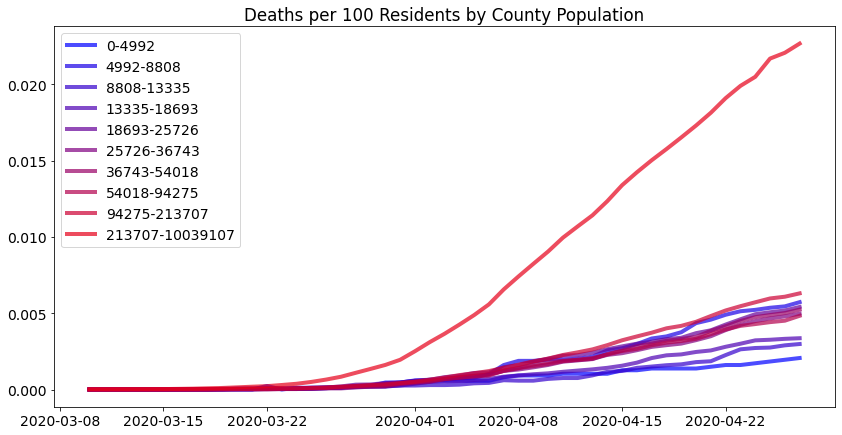

In [12]:
draw_plot(series_by_pop, "County Population", "Deaths_per_100", "Deaths per 100 Residents")

# Part 2: Income

In [13]:
# Read in income statistics by county.
income_data_file = os.path.join(_DATA_DIR, "us_counties_income.csv")
income = pd.read_csv(income_data_file).set_index("FIPS")
income

,County,State,"Percent Less than $10,000","Percent $10,000 to $14,999","Percent $15,000 to $24,999","Percent $25,000 to $34,999","Percent $35,000 to $49,999","Percent $50,000 to $74,999","Percent $75,000 to $99,999","Percent $100,000 to $149,999","Percent $150,000 to $199,999","Percent $200,000 or more",Median income (dollars),Mean income (dollars)
FIPS,,,,,,,,,,,,,,
1001,Autauga,Alabama,7.1,5.8,10.1,7.9,11.9,18.1,14.1,16.6,5.5,3.1,58786.0,75515.0
1003,Baldwin,Alabama,5.4,5.2,9.2,11.0,13.5,19.3,12.3,13.6,5.5,5.1,55962.0,77212.0
1005,Barbour,Alabama,13.3,8.9,16.5,12.1,14.2,14.3,8.8,9.1,1.3,1.4,34186.0,47909.0
1007,Bibb,Alabama,6.4,8.2,12.9,11.1,15.0,16.7,14.6,10.2,3.1,1.7,45340.0,58529.0
1009,Blount,Alabama,8.4,5.6,11.4,12.6,13.1,20.9,11.9,10.6,3.5,1.9,48695.0,60646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72145,Vega Baja Municipio,Puerto Rico,28.9,12.8,17.6,13.3,10.0,11.5,3.4,1.7,0.5,0.4,19096.0,27927.0
72147,Vieques Municipio,Puerto Rico,28.8,19.8,16.7,13.8,12.5,6.2,0.4,1.7,0.0,0.0,15539.0,22635.0
72149,Villalba Municipio,Puerto Rico,24.3,14.0,20.0,14.9,13.2,9.2,2.5,1.5,0.2,0.2,19855.0,29895.0


In [14]:
# Outer join the income data with our time series
cases_with_income = cases.join(income, rsuffix="_Census", how="left")
cases_with_income

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,County_Census,...,"Percent $15,000 to $24,999","Percent $25,000 to $34,999","Percent $35,000 to $49,999","Percent $50,000 to $74,999","Percent $75,000 to $99,999","Percent $100,000 to $149,999","Percent $150,000 to $199,999","Percent $200,000 or more",Median income (dollars),Mean income (dollars)
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Autauga,...,10.1,7.9,11.9,18.1,14.1,16.6,5.5,3.1,58786.0,75515.0
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Baldwin,...,9.2,11.0,13.5,19.3,12.3,13.6,5.5,5.1,55962.0,77212.0
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Barbour,...,16.5,12.1,14.2,14.3,8.8,9.1,1.3,1.4,34186.0,47909.0
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Bibb,...,12.9,11.1,15.0,16.7,14.6,10.2,3.1,1.7,45340.0,58529.0
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Blount,...,11.4,12.6,13.1,20.9,11.9,10.6,3.5,1.9,48695.0,60646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Sweetwater,...,8.2,6.1,10.7,17.8,16.4,21.6,6.4,4.2,73008.0,84961.0
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Teton,...,6.3,4.7,9.4,17.6,15.1,19.9,6.9,15.7,83831.0,128868.0
56041,Wyoming,Uinta,20226,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Uinta,...,9.5,8.5,14.6,19.0,13.9,15.5,7.3,1.8,58235.0,71005.0


In [15]:
# How many counties do we not have income data for?
cases_with_income[cases_with_income["Median income (dollars)"].isna()]

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,County_Census,...,"Percent $15,000 to $24,999","Percent $25,000 to $34,999","Percent $35,000 to $49,999","Percent $50,000 to $74,999","Percent $75,000 to $99,999","Percent $100,000 to $149,999","Percent $150,000 to $199,999","Percent $200,000 or more",Median income (dollars),Mean income (dollars)
FIPS,,,,,,,,,,,,,,,,,,,,,
35039,New Mexico,Rio Arriba,38921,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Rio Arriba,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Since we're only missing one county's income stats, just filter out that county.
cases_with_income = cases_with_income[~cases_with_income["Median income (dollars)"].isna()]
cases_with_income

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,County_Census,...,"Percent $15,000 to $24,999","Percent $25,000 to $34,999","Percent $35,000 to $49,999","Percent $50,000 to $74,999","Percent $75,000 to $99,999","Percent $100,000 to $149,999","Percent $150,000 to $199,999","Percent $200,000 or more",Median income (dollars),Mean income (dollars)
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Autauga,...,10.1,7.9,11.9,18.1,14.1,16.6,5.5,3.1,58786.0,75515.0
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Baldwin,...,9.2,11.0,13.5,19.3,12.3,13.6,5.5,5.1,55962.0,77212.0
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Barbour,...,16.5,12.1,14.2,14.3,8.8,9.1,1.3,1.4,34186.0,47909.0
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Bibb,...,12.9,11.1,15.0,16.7,14.6,10.2,3.1,1.7,45340.0,58529.0
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Blount,...,11.4,12.6,13.1,20.9,11.9,10.6,3.5,1.9,48695.0,60646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Sweetwater,...,8.2,6.1,10.7,17.8,16.4,21.6,6.4,4.2,73008.0,84961.0
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Teton,...,6.3,4.7,9.4,17.6,15.1,19.9,6.9,15.7,83831.0,128868.0
56041,Wyoming,Uinta,20226,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Uinta,...,9.5,8.5,14.6,19.0,13.9,15.5,7.3,1.8,58235.0,71005.0


In [17]:
# Label counties by decile of medium income.
median_income_quantiles = cases_with_income["Median income (dollars)"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
median_income = cases[["State", "County", "Population"]].copy()
median_income["Median_Income_Bin"] = pd.cut(cases_with_income["Median income (dollars)"], 
                                        bins=([0.0] + median_income_quantiles.to_list()))
median_income

,State,County,Population,Median_Income_Bin
FIPS,,,,
1001,Alabama,Autauga,55869,"(55683.0, 59898.0]"
1003,Alabama,Baldwin,223234,"(55683.0, 59898.0]"
1005,Alabama,Barbour,24686,"(0.0, 36877.0]"
1007,Alabama,Bibb,22394,"(44000.0, 47063.0]"
1009,Alabama,Blount,57826,"(47063.0, 49888.0]"
...,...,...,...,...
56037,Wyoming,Sweetwater,42343,"(67591.0, 136268.0]"
56039,Wyoming,Teton,23464,"(67591.0, 136268.0]"
56041,Wyoming,Uinta,20226,"(55683.0, 59898.0]"


In [18]:
# Group all the time series by decile of median income

cases_with_bin = cases.copy()
cases_with_bin["Median_Income_Bin"] = median_income["Median_Income_Bin"]

# TODO: Replace outliers with interpolated values before aggregating.

series_by_median_income = cases_with_bin.groupby("Median_Income_Bin").aggregate({
    "Population": "sum",
    "Confirmed": "sum",
    "Deaths" : "sum",
    "Recovered" : "sum"
})

# Use the total populations to compute aggregated normalized time series
series_by_median_income["Confirmed_per_100"] = 100.0 * series_by_median_income["Confirmed"] / series_by_median_income["Population"]
series_by_median_income["Deaths_per_100"] = 100.0 * series_by_median_income["Deaths"] / series_by_median_income["Population"]
series_by_median_income["Recovered_per_100"] = 100.0 * series_by_median_income["Recovered"] / series_by_median_income["Population"]

series_by_median_income

,Population,Confirmed,Deaths,Recovered,Confirmed_per_100,Deaths_per_100,Recovered_per_100
Median_Income_Bin,,,,,,,
"(0.0, 36877.0]",5753313,"[0, 2, 2, 3, 3, 3, 3, 10, 15, 25, 47, 74, 114,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 3.476257940424934e-05, 3.476257940424934...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(36877.0, 40893.0]",11023413,"[4, 15, 33, 57, 115, 129, 179, 302, 539, 964, ...","[0, 0, 0, 0, 1, 3, 6, 9, 17, 25, 39, 54, 63, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.628640240549819e-05, 0.0001360740090206182,...","[0.0, 0.0, 0.0, 0.0, 9.071600601374547e-06, 2....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(40893.0, 44000.0]",12273653,"[3, 4, 5, 11, 14, 16, 28, 47, 67, 92, 139, 193...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.444260074812283e-05, 3.259013433083044e-05,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(44000.0, 47063.0]",18838517,"[6, 8, 15, 24, 34, 45, 65, 86, 119, 182, 273, ...","[0, 0, 0, 1, 1, 1, 2, 3, 4, 4, 8, 8, 13, 17, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.184964081832981e-05, 4.246618775777308e-05,...","[0.0, 0.0, 0.0, 5.308273469721635e-06, 5.30827...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(47063.0, 49888.0]",22923956,"[15, 23, 21, 37, 66, 69, 107, 172, 271, 368, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 6, 8, 11,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6.54337322929777e-05, 0.00010033172284923248,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(49888.0, 52583.0]",22776344,"[8, 18, 28, 38, 60, 71, 111, 159, 198, 305, 42...","[0, 0, 0, 0, 0, 0, 1, 1, 2, 5, 7, 9, 14, 15, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.5124162157016945e-05, 7.902936485328813e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.3905202696271...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(52583.0, 55683.0]",30702299,"[21, 32, 37, 49, 97, 109, 138, 196, 285, 408, ...","[2, 3, 3, 3, 3, 4, 4, 5, 5, 8, 9, 12, 14, 18, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6.839878668369428e-05, 0.00010422672256562937...","[6.514170160351836e-06, 9.771255240527753e-06,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(55683.0, 59898.0]",35189201,"[28, 52, 88, 144, 219, 245, 392, 623, 1100, 19...","[0, 0, 0, 0, 1, 3, 8, 13, 23, 35, 54, 76, 94, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7.956986576648899e-05, 0.00014777260785205098...","[0.0, 0.0, 0.0, 0.0, 2.8417809202317494e-06, 8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
"(59898.0, 67591.0]",74790499,"[106, 174, 231, 313, 456, 474, 703, 1035, 1614...","[1, 3, 3, 4, 3, 7, 11, 18, 32, 46, 64, 83, 107...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.00014172923221170112, 0.0002326498717437358...","[1.3370682284122747e-06, 4.011204685236824e-06...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


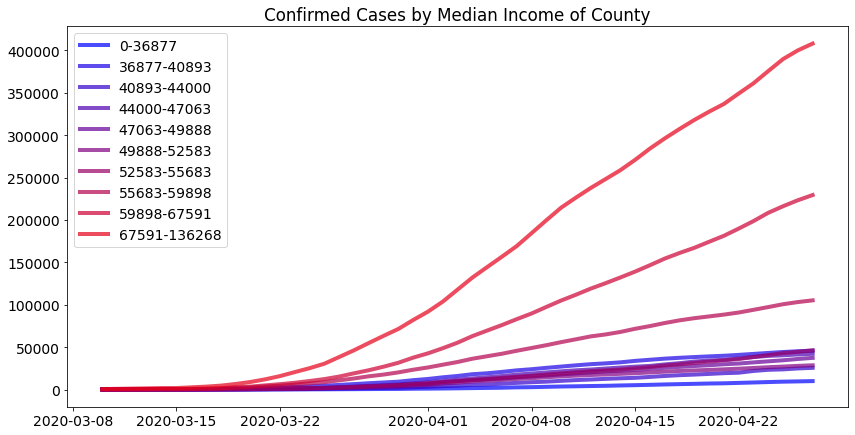

In [19]:
draw_plot(series_by_median_income, "Median Income of County", "Confirmed", "Confirmed Cases")

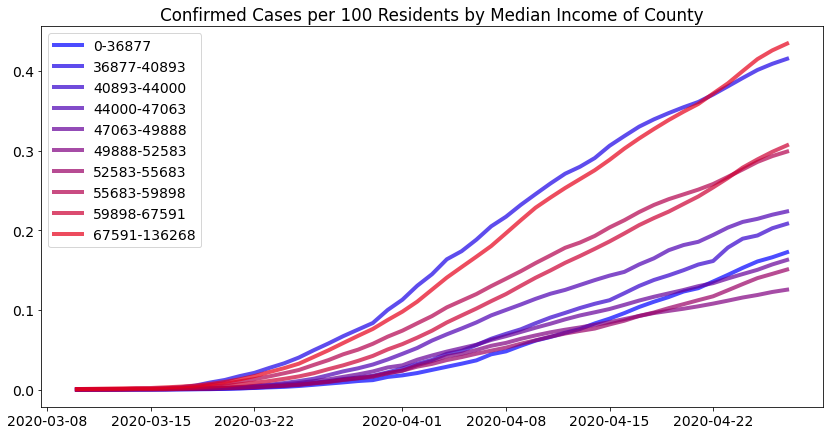

In [20]:
draw_plot(series_by_median_income, "Median Income of County", "Confirmed_per_100", "Confirmed Cases per 100 Residents")

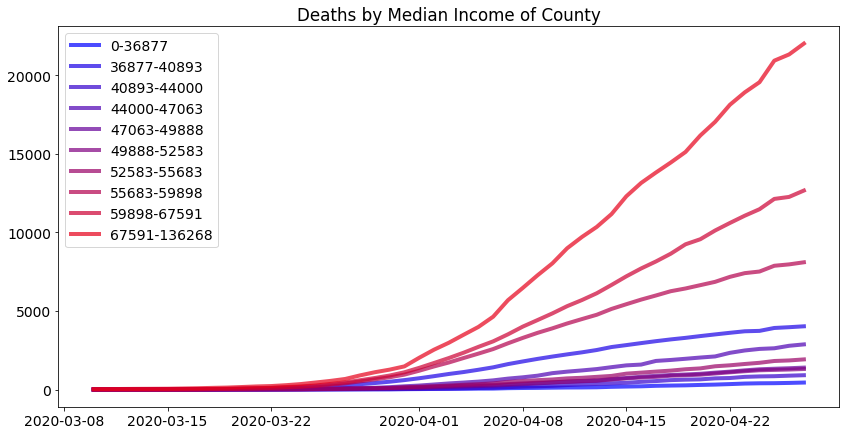

In [21]:
draw_plot(series_by_median_income, "Median Income of County", "Deaths", "Deaths")

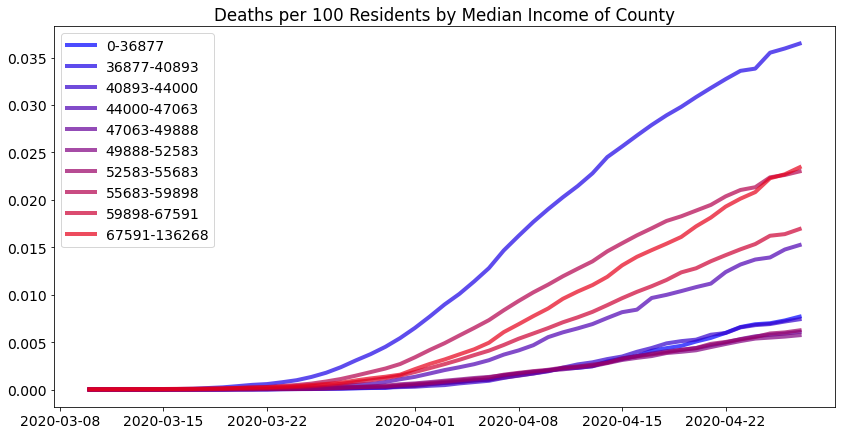

In [22]:
draw_plot(series_by_median_income, "Median Income of County", "Deaths_per_100", "Deaths per 100 Residents")